# Lesson 4

## Step 1: Preparing the data

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Softmax
from torch.nn import Module

from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from torch.utils.data import SubsetRandomSampler
from sklearn.model_selection import train_test_split


from tqdm import tqdm_notebook

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split

from torchvision import transforms


import os
import warnings
warnings.filterwarnings('ignore')

### DATASETS & DATALOADERS

Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

More info: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [2]:
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, path):
        df = pd.read_csv(path)
        # store the inputs and outputs
        self.X = df.values[:, :-1]
        self.y = df.values[:, -1]
        # ensure input data is floats
        self.X = self.X.astype('float32')
        self.y = LabelEncoder().fit_transform(self.y)
 
    # number of rows in the dataset
    def __len__(self):
        return len(self.X)
 
    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]
 
    # get indexes for train and test rows
    def get_splits(self, n_test=0.2):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

In [3]:
# prepare the dataset
def prepare_data(path):
    # load the dataset
    dataset = CSVDataset(path)
    # calculate split
    train, test = dataset.get_splits()
    # prepare data loaders
    train_dl = DataLoader(train,batch_size=32, shuffle=True)
    test_dl = DataLoader(test,batch_size=32, shuffle=False)
    return train_dl, test_dl

## Step 2: Prepearing module

### Module

Pytorch uses modules to represent neural networks: https://pytorch.org/docs/stable/generated/torch.nn.Module.html

Xavier and kaiming weight initialization: https://pytorch.org/docs/stable/nn.init.html

In [4]:
# model definition
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # second hidden layer
        self.hidden2 = Linear(10, 8)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # third hidden layer and output
        self.hidden3 = Linear(8, 2)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Softmax(dim = 1)
 
    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
         # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # third hidden layer and output
        X = self.hidden3(X)
        X = self.act3(X)
        return X

In [5]:
# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.001)
    # enumerate epochs
    for epoch in tqdm_notebook(range(500)):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()

In [6]:
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        yhat = np.argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape(-1, 1)
        yhat = yhat.reshape(-1, 1)
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc

In [7]:
# prepare the data
path = 'model_data.csv'

In [8]:
train_dl, test_dl = prepare_data(path)
print(len(train_dl.dataset), len(test_dl.dataset))

4256 1064


In [9]:
train_dl

In [10]:
# define the netw
model = MLP(12)

In [11]:
model

MLP(
  (hidden1): Linear(in_features=12, out_features=10, bias=True)
  (act1): ReLU()
  (hidden2): Linear(in_features=10, out_features=8, bias=True)
  (act2): ReLU()
  (hidden3): Linear(in_features=8, out_features=2, bias=True)
  (act3): Softmax(dim=1)
)

In [12]:
# train the model
train_model(train_dl, model)

  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
# evaluate the model
acc = evaluate_model(test_dl, model)
print('Accuracy: %.3f' % acc)

Accuracy: 0.941


# Example on MNIST dataset

In [14]:
for dirname, _, filenames in os.walk('/digit-recognizer'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [15]:
train_df = pd.read_csv("digit-recognizer/train.csv")
test_df = pd.read_csv("digit-recognizer/test.csv")

In [16]:
print(train_df.shape , test_df.shape)

(42000, 785) (28000, 784)


In [17]:
train_df['label'].value_counts().sort_index()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

In [18]:
class CustomMNISTDataset(Dataset):
    def __init__(self, csv_name, img_dir, transform=None, target_transform=None , label_name = "label"):
        
        self.img_filename = csv_name
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.label_name = label_name
        
        img_path = os.path.join(self.img_dir, self.img_filename)
        self.img_df = pd.read_csv(img_path)

    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, idx):
        
        # Extracting all the other columns except label_name
        img_cols = [ i for i in self.img_df.columns if i not in self.label_name]
        
        image = self.img_df.iloc[[idx]][img_cols].values

        # Reshaping the array from 1*784 to 28*28
        image = image.reshape(28,28)
        # image = image.astype(float)

        # Scaling the image so that the values only range between 0 and 1
        image = image/255.0
        
        
        if self.transform:
            image = self.transform(image)
    
        image = image.to(torch.float)    
        
        if self.label_name in self.img_df.columns:
            
            if self.target_transform:
                label = self.target_transform(label)
            label = int(self.img_df.iloc[[idx]][self.label_name].values)
            return image, label
        
        # Exceptions for test where labels are absent
        else :
            return image

In [19]:
indices = list(range(len(train_df)))
train_indices , test_indices = train_test_split(indices, test_size=0.1, stratify=train_df['label'])

len(train_indices) , len(test_indices) , len(train_df)

train_subset = train_df.loc[train_indices]
val_subset = train_df.loc[test_indices]

print("Distribution of target values in training dataset ; ")
print( train_subset['label'].value_counts().sort_index() / train_subset['label'].value_counts().sort_index().sum() )

print("Distribution of target values in validation dataset ; ")
print( val_subset['label'].value_counts().sort_index() / val_subset['label'].value_counts().sort_index().sum() )

Distribution of target values in training dataset ; 
0    0.098386
1    0.111534
2    0.099444
3    0.103598
4    0.096958
5    0.090344
6    0.098492
7    0.104788
8    0.096746
9    0.099709
Name: label, dtype: float64
Distribution of target values in validation dataset ; 
0    0.098333
1    0.111429
2    0.099524
3    0.103571
4    0.096905
5    0.090476
6    0.098571
7    0.104762
8    0.096667
9    0.099762
Name: label, dtype: float64


In [20]:
# Crerating a temp dataset
train_csv_name = "train.csv"
test_csv_name = "test.csv"
img_dir = "digit-recognizer/"

# Converting X variables to Tensors
transforms = transforms.Compose( [transforms.ToTensor() , transforms.Normalize((0.5,), (0.5,)) , ] )

# Converting y-labels to one hot encoding
# target_transform = Lambda(lambda y: torch.zeros(
#     len(train_df['label'].unique()), dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))
# This is not need since we are going to be using cross entropy loss function

label_name = "label"

train_dataset = CustomMNISTDataset(csv_name = train_csv_name , img_dir = img_dir,
                                   transform = transforms , target_transform = None , label_name = label_name)

# Inspecting the fist line item under dataset
x0 , y0 = train_dataset[0]
print(x0.shape , y0)

torch.Size([1, 28, 28]) 1


In [21]:
transforms

Compose(
    ToTensor()
    Normalize(mean=(0.5,), std=(0.5,))
)

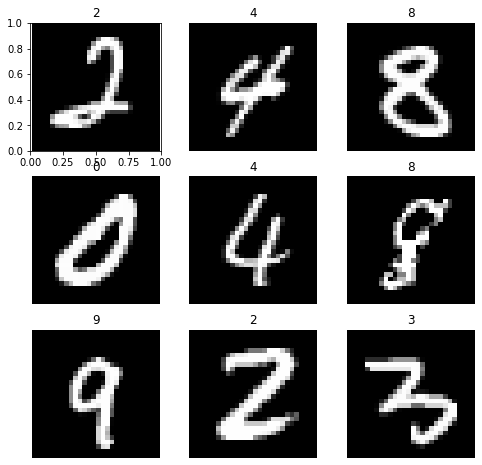

In [22]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
figure.add_subplot(rows, cols, 1)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    sample_img , sample_lbl = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(sample_lbl)
    plt.axis("off")
    plt.imshow(sample_img.squeeze(), cmap="gray")
plt.show()

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
torch.cuda.is_available()
x0 = x0.to(device)
print("x0" , x0.is_cuda)

Using device: cuda
x0 True


In [24]:
indices = list(range(len(train_df)))
train_indices , valid_indices = train_test_split(indices, test_size=0.1, stratify=train_df['label'])

In [25]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(test_indices)

In [26]:
train_dataloader = torch.utils.data.DataLoader(train_dataset , batch_size=1024, sampler=train_sampler, num_workers=16)
valid_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, sampler=valid_sampler, num_workers=16)

In [27]:
# x0 , y0 = next(iter(train_dataloader))
# x0.shape , y0.shape

In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [29]:
# device = "cpu"

In [30]:
class MNIST_MODEL(Module):
    def __init__(self):
        super(MNIST_MODEL, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            Linear(784, 128),
            ReLU(),
            Linear(128, 64),
            ReLU(),
            Linear(64, 10)
            ## Softmax layer ignored since the loss function defined is nn.CrossEntropy()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return  logits

In [31]:
model = MNIST_MODEL().to(device)
print(model)

MNIST_MODEL(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [32]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=3e-3)

In [33]:
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter

In [37]:
def train(dataloader, model, loss_fn, optimizer):
    
    # Total size of dataset for reference
    size = 0
    
    # places your model into training mode
    model.train()
    
    # loss batch
    batch_loss = {}
    batch_accuracy = {}
    
    correct = 0
    _correct = 0
    
    
    
    # Gives X , y for each batch
    for batch, (X, y) in enumerate(dataloader):
        
        # Converting device to cuda
        X, y = X.to(device), y.to(device)
        model.to(device)
        
        # Compute prediction error / loss
        # 1. Compute y_pred 
        # 2. Compute loss between y and y_pred using selectd loss function
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # Backpropagation on optimizing for loss
        # 1. Sets gradients as 0 
        # 2. Compute the gradients using back_prop
        # 3. update the parameters using the gradients from step 2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        _correct = (y_pred.argmax(1) == y).type(torch.float).sum().item()
        _batch_size = len(X)
        
        correct += _correct
        
        # Updating loss_batch and batch_accuracy
        batch_loss[batch] = loss.item()
        batch_accuracy[batch] = _correct/_batch_size
        
        size += _batch_size
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}]")
    
    correct/=size
    print(f"Train Accuracy: {(100*correct):>0.1f}%")
    
    return batch_loss , batch_accuracy

In [38]:
def validation(dataloader, model, loss_fn):
    
    # Total size of dataset for reference
    size = 0
    num_batches = len(dataloader)
    
    # Setting the model under evaluation mode.
    model.eval()

    test_loss, correct = 0, 0
    
    _correct = 0
    _batch_size = 0
    
    batch_loss = {}
    batch_accuracy = {}
    
    with torch.no_grad():
        
        # Gives X , y for each batch
        for batch , (X, y) in enumerate(dataloader):
            
            X, y = X.to(device), y.to(device)
            model.to(device)
            pred = model(X)
            
            batch_loss[batch] = loss_fn(pred, y).item()
            test_loss += batch_loss[batch]
            _batch_size = len(X)
            
            _correct = (pred.argmax(1) == y).type(torch.float).sum().item()
            correct += _correct
            
            size+=_batch_size
            batch_accuracy[batch] = _correct/_batch_size
            
            
            
    
    ## Calculating loss based on loss function defined
    test_loss /= num_batches
    
    ## Calculating Accuracy based on how many y match with y_pred
    correct /= size
    
    print(f"Valid Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return batch_loss , batch_accuracy

In [39]:
train_batch_loss = []
train_batch_accuracy = []
valid_batch_accuracy = []
valid_batch_loss = []
train_epoch_no = []
valid_epoch_no = []

In [ ]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    _train_batch_loss , _train_batch_accuracy = train(train_dataloader, model, loss_fn, optimizer)
    _valid_batch_loss , _valid_batch_accuracy = validation(valid_dataloader, model, loss_fn)
    for i in tqdm_notebook(range(len(_train_batch_loss)), desc = "Train"):
        train_batch_loss.append(_train_batch_loss[i])
        train_batch_accuracy.append(_train_batch_accuracy[i])
        train_epoch_no.append( t + float((i+1)/len(_train_batch_loss)))     
    for i in tqdm_notebook(range(len(_valid_batch_loss)), desc = "Validation"):
        valid_batch_loss.append(_valid_batch_loss[i])
        valid_batch_accuracy.append(_valid_batch_accuracy[i])
        valid_epoch_no.append( t + float((i+1)/len(_valid_batch_loss)))     
print("Done!")

Epoch 1
-------------------------------


In [ ]:
figure = plt.figure(figsize=(16, 16))


figure.add_subplot(2, 2, 1)
plt.plot(train_epoch_no , train_batch_accuracy)
plt.title("Train Batch Accuracy")
plt.xlabel("Epochs") 
plt.ylabel("Train Accuracy") 

figure.add_subplot(2, 2, 2)
plt.plot(train_epoch_no , train_batch_loss)
plt.title("Train Batch Loss")
plt.xlabel("Epochs") 
plt.ylabel("Train Loss") 

figure.add_subplot(2, 2, 3)
plt.plot(valid_epoch_no , valid_batch_accuracy)
plt.title("Valid Batch Accuracy")
plt.xlabel("Epochs") 
plt.ylabel("Train Accuracy") 

figure.add_subplot(2, 2, 4)
plt.plot(valid_epoch_no , valid_batch_loss)
plt.title("Valid Batch Loss")
plt.xlabel("Epochs") 
plt.ylabel("Train Loss") 


plt.show()